In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.io import sql
import sqlite3
conn = sqlite3.connect('eliflo.db', detect_types=sqlite3.PARSE_DECLTYPES)

In [3]:
#The data has information about when eliflo users signed up and other characteristics about them.
data = pd.read_csv('eliflo_users.csv', low_memory=False)
data.head()

,customerid,datecreated,source,mailinglist,marketingenabled,orgid,invitedby
0,1,1398138810,GUEST_INVITE,1,0,11,10803
1,2,1384487104,ORG_INVITE,0,0,1,316
2,3,1363734892,ORG_INVITE,0,0,94,1525
3,4,1369123768,GUEST_INVITE,0,0,1,5151
4,5,1358417660,GUEST_INVITE,0,0,193,5240


In [4]:
#Convert data frame to sqlite
data.to_sql('eliflo_users',
            con=conn,
            if_exists='replace',
            index=False)

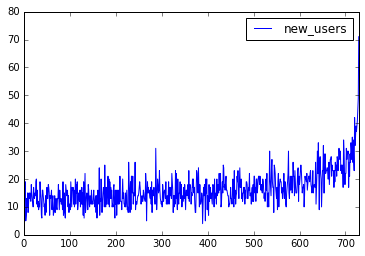

In [5]:
#Show signups per day
a=sql.read_sql('''
select date(datecreated, 'unixepoch') as day_created, count(*) as new_users from eliflo_users group by 1
''', con=conn)
a.plot()

In [6]:
#What are the most popular sources that users came from?
a=sql.read_sql('''
select source, count(*) as new_users from eliflo_users group by 1 order by 2 desc;
''', con=conn)
a

,source,new_users
0,ORG_INVITE,4254
1,GUEST_INVITE,2163
2,PERSONAL_PROJECTS,2111
3,SIGNUP,2087
4,SIGNUP_GOOGLE_AUTH,1385


In [8]:
#Get data about these users subsequent activity
activity = pd.read_csv('eliflo_activity.csv', low_memory=False)
activity.head()

,customerid,timestamp
0,1,1398138810
1,2,1384487104
2,2,1385696704
3,2,1386560704
4,2,1387943104


In [9]:
#Convert activity to sqlite
activity.to_sql('eliflo_activity',
            con=conn,
            if_exists='replace',
            index=False)

In [11]:
#Example of a subquery
a=sql.read_sql('''
select
visits,
count(distinct(customerid))
from
(
select
    customerid,
    count(*) as visits
from
    eliflo_activity
group by 1 
order by 2
) q
group by 1 order by 2 desc;
    ''', con=conn)
a.head()

,visits,count(distinct(customerid))
0,1,6235
1,2,340
2,3,241
3,4,181
4,5,110


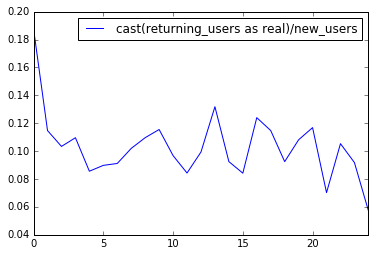

In [13]:
#This query show the percentage of customers per cohort that were active in the second week after they signed up.
a=sql.read_sql('''
select 
    a.day_created,
    cast(returning_users as real)/new_users
from
(
select
    substr(date(datecreated, 'unixepoch'), 1,7) as day_created,
    count(distinct(customerid)) as new_users
from
    eliflo_users 
group by 1
) a
left join
(
select
    substr(date(a.datecreated, 'unixepoch'), 1,7) as day_created,
    count(distinct(b.customerid)) as returning_users
from
    eliflo_users a
left join
    eliflo_activity b
on
    a.customerid = b.customerid
where
    b.timestamp between a.datecreated + 7*86400 and a.datecreated + 14*86400
group by 1
) b
on a.day_created = b.day_created
    ''', con=conn)
a.plot()

In [15]:
#This query looks at the retention rate for a selected cohort.
a=sql.read_sql('''
select 
    month,
    cast(returning_users as real)/initial_cohort as retention_Rate
from
(select
   cast((b.timestamp - a.datecreated)/(86400*30) as int) as month,
    count(distinct(b.customerid)) as returning_users
from
    eliflo_users a
left join
    eliflo_activity b
on
    a.customerid = b.customerid
where
    substr(date(a.datecreated, 'unixepoch'), 1,7) = '2012-06' and
    cast((b.timestamp - a.datecreated)/(86400*30) as int) >= 0
group by 1) a,
(select
    count(distinct(customerid)) as initial_cohort
from
    eliflo_users a
where
    substr(date(a.datecreated, 'unixepoch'), 1,7) = '2012-06' 
)
    ''', con=conn)
a.head(100)

,month,retention_Rate
0,0,0.715711
1,1,0.187032
2,2,0.169576
3,3,0.157107
4,4,0.142145
5,5,0.137157
6,6,0.137157
7,7,0.129676
8,8,0.124688
9,9,0.122195


In [ ]:
#Generalizing the calculation of a retention curve
def constructRetentionCurve(month):
    string = '''
    select 
        month,
        cast(returning_users as real)/initial_cohort as retention_Rate
    from
    (select
        cast((b.timestamp - a.datecreated)/(86400*30) as int) as month,
        count(distinct(b.customer)) as returning_users
    from
        eliflo_users a
    left join
        eliflo_activity b
    on
        a.customerid = b.customer
    where
        substr(date(a.datecreated, 'unixepoch'), 1,7) = '%s' and
        cast((b.timestamp - a.datecreated)/(86400*30) as int) >= 0
    group by 1) a,
    (select
        count(distinct(customerid)) as initial_cohort
    from
        eliflo_users a
    where
        substr(date(a.datecreated, 'unixepoch'), 1,7) = '%s'  
    )
    ''' % (month, month)
    return string

In [ ]:
a=sql.read_sql(constructRetentionCurve('2012-10'), con=conn)
b=sql.read_sql(constructRetentionCurve('2012-06'), con=conn)
#How do we join the retention curves together?